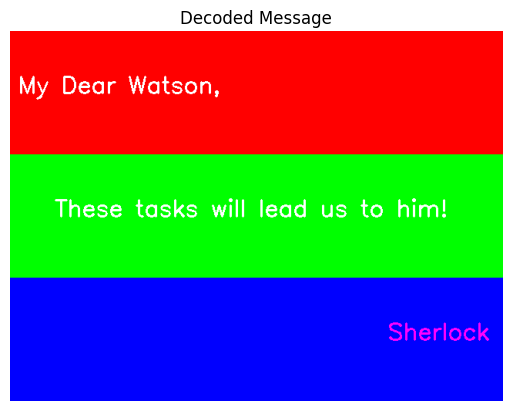

In [26]:
#Task 1

#a)
import cv2
import numpy as np
import matplotlib.pyplot as plt
     

secret = cv2.imread("_Fall_2025__ROB_GY_6203_HW1/data/for_watson.png", cv2.IMREAD_COLOR)
if secret is None:
    print("Image not loaded. Check the path and filename.")
    exit()

_, thresh = cv2.threshold(secret, 0, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')
cv2.imwrite('decoded_message.png', thresh)
plt.title('Decoded Message')
plt.axis('off')
plt.show()

#no unified way to solve it, different ways to solve it

100%|██████████| 26.4M/26.4M [00:46<00:00, 566kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 232kB/s]
100%|██████████| 4.42M/4.42M [00:07<00:00, 592kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 3.42MB/s]


Epoch [1/20], Loss: 0.0596
Epoch [2/20], Loss: 0.0270
Epoch [3/20], Loss: 0.0230
Epoch [4/20], Loss: 0.0214
Epoch [5/20], Loss: 0.0200
Epoch [6/20], Loss: 0.0190
Epoch [7/20], Loss: 0.0181
Epoch [8/20], Loss: 0.0175
Epoch [9/20], Loss: 0.0170
Epoch [10/20], Loss: 0.0166
Epoch [11/20], Loss: 0.0162
Epoch [12/20], Loss: 0.0158
Epoch [13/20], Loss: 0.0155
Epoch [14/20], Loss: 0.0151
Epoch [15/20], Loss: 0.0149
Epoch [16/20], Loss: 0.0146
Epoch [17/20], Loss: 0.0144
Epoch [18/20], Loss: 0.0141
Epoch [19/20], Loss: 0.0139
Epoch [20/20], Loss: 0.0137


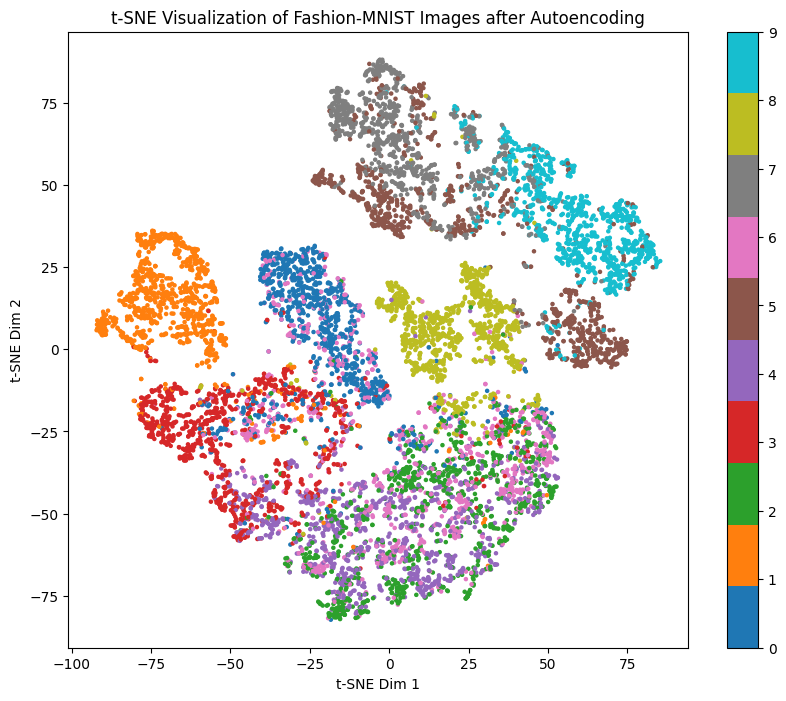

In [ ]:
# Task 2: Dimensionality Reduction with Autoencoder + t-SNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load Fashion-MNIST dataset
# ----------------------------
transform = transforms.ToTensor()  # convert images to tensors in [0,1]

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Flatten images for autoencoder
X_train_tensor = train_dataset.data.view(-1, 28*28).float() / 255.0
y_train = train_dataset.targets
X_test_tensor  = test_dataset.data.view(-1, 28*28).float() / 255.0
y_test  = test_dataset.targets

# ----------------------------
# 2. Define Autoencoder
# ----------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32)  # latent space
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # normalized pixel values
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ----------------------------
# 3. Create DataLoader
# ----------------------------
train_dataset_tensor = TensorDataset(X_train_tensor, X_train_tensor)  # autoencoder: input=target
train_loader = DataLoader(train_dataset_tensor, batch_size=256, shuffle=True)

# ----------------------------
# 4. Train Autoencoder
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for data_in, target in train_loader:
        data_in, target = data_in.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data_in)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data_in.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# ----------------------------
# 5. Encode test images and apply t-SNE
# ----------------------------
with torch.no_grad():
    encoded_test = model.encoder(X_test_tensor.to(device)).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(encoded_test)

# ----------------------------
# 6. Visualize
# ----------------------------
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE Visualization of Fashion-MNIST Images after Autoencoding')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.show()

#sources
# 1. https://github.com/Rahulraj31/Autoencoder_MNIST-Fashion/blob/main/MNIST_Autoencoders.ipynb
# 2. https://github.com/najeebuddinm98/vae_fashionmnist/blob/main/VAE_fashionmnist.ipynb


#a lot of randomness in it ; what matters is the features are seperable

In [21]:
#Task 3 April Tags

import cv2
import glob
import pyapriltags
import numpy as np

#using april tag use actual april tags // use aruco tag detector instead (aruco and open cv) ; 
#both have dictionaries 3x3 4x4 5x5 (one of the paremeters i need to pass to the detector)
#better to create the tag myself and know what dictionary is being used. 

# Load all calibration images from a folder
image_files = glob.glob('Task3_april_calib/*.jpg')
images = [cv2.imread(fname) for fname in image_files]

# Initialize the detector
detector = pyapriltags.Detector()

# Store detected corners and IDs
all_corners = []
all_ids = []

for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    results = detector.detect(gray)
    corners = [r.corners for r in results]
    ids = [r.tag_id for r in results]
    all_corners.append(corners)
    all_ids.append(ids)

# Define the grid size and tag spacing (in meters)
grid_rows = 6
grid_cols = 8
tag_size = 0.04  # 4 cm

# Generate 3D object points for each tag
object_points = []
for row in range(grid_rows):
    for col in range(grid_cols):
        # Each tag's center
        object_points.append([col * tag_size, row * tag_size, 0])
object_points = np.array(object_points, dtype=np.float32)

image_points = []
object_points_list = []

for corners, ids in zip(all_corners, all_ids):
    img_pts = []
    obj_pts = []
    for i, tag_id in enumerate(ids):
        img_pts.extend(corners[i])  # 4 corners per tag
        # Map tag_id to object_points index
        obj_pts.extend([object_points[tag_id]] * 4)
    image_points.append(np.array(img_pts, dtype=np.float32))
    object_points_list.append(np.array(obj_pts, dtype=np.float32))

# Filter out empty sets
filtered_image_points = []
filtered_object_points_list = []

for img_pts, obj_pts in zip(image_points, object_points_list):
    if len(img_pts) > 0 and len(obj_pts) > 0:
        filtered_image_points.append(img_pts)
        filtered_object_points_list.append(obj_pts)

print("Number of valid image sets:", len(filtered_image_points))
for i, (img_pts, obj_pts) in enumerate(zip(filtered_image_points, filtered_object_points_list)):
    print(f"Set {i}: img_pts={len(img_pts)}, obj_pts={len(obj_pts)}")

# Only use filtered lists for calibration
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    filtered_object_points_list, filtered_image_points, images[0].shape[1::-1], None, None
)

print("Camera matrix:\n", camera_matrix)
print("Distortion coefficients:\n", dist_coeffs)


#source
#1. https://github.com/AprilRobotics/apriltag
#2. https://github.com/abhishekpadalkar/camera_calibration/blob/master/camera_calibration.py

 

Number of valid image sets: 0


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\calibration.cpp:1379: error: (-215:Assertion failed) nimages > 0 in function 'cv::calibrateCameraRO'


In [ ]:
#Task 3 Aruco Markers

import cv2
import glob
import numpy as np

# --- Load calibration images ---
image_files = glob.glob('task3_calib_img/*.jpg')
images = [cv2.imread(fname) for fname in image_files if cv2.imread(fname) is not None]
print("Loaded", len(images), "images.")

# --- Use correct ArUco dictionary ---
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

# --- Detect corners & IDs ---
all_corners = []
all_ids = []

for i, img in enumerate(images):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = detector.detectMarkers(gray)
    if ids is not None:
        all_corners.append(corners)
        all_ids.append(ids.flatten())
        print(f"Image {i}: detected {len(ids)} markers")
    else:
        print(f"Image {i}: no markers detected")

# --- Define grid and tag spacing ---
# Adjust to your printed pattern
grid_rows = 6
grid_cols = 8
tag_size = 0.04  # 4 cm center-to-center

# 3D points (each tag’s center)
object_points = []
for row in range(grid_rows):
    for col in range(grid_cols):
        object_points.append([col * tag_size, row * tag_size, 0])
object_points = np.array(object_points, dtype=np.float32)

# --- Build image–object correspondences ---
image_points = []
object_points_list = []

for corners, ids in zip(all_corners, all_ids):
    img_pts = []
    obj_pts = []
    for i, tag_id in enumerate(ids):
        if tag_id < len(object_points):  # sanity check
            img_pts.extend(corners[i][0])
            obj_pts.extend([object_points[tag_id]] * 4)
    if len(img_pts) > 0:
        image_points.append(np.array(img_pts, dtype=np.float32))
        object_points_list.append(np.array(obj_pts, dtype=np.float32))

print("Valid sets:", len(image_points))

# --- Calibrate camera ---
if len(image_points) > 0:
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        object_points_list,
        image_points,
        images[0].shape[1::-1],
        None,
        None
    )
    print("\nCalibration successful:", ret)
    print("Camera matrix (K):\n", camera_matrix)
    print("Distortion coefficients:\n", dist_coeffs)
else:
    print("No valid marker sets for calibration.")


np.savez("camera_calib_aruco.npz", K=camera_matrix, D=dist_coeffs)



Loaded 15 images.
Image 0: detected 18 markers
Image 1: detected 20 markers
Image 2: detected 19 markers
Image 3: detected 19 markers
Image 4: detected 20 markers
Image 5: detected 17 markers
Image 6: detected 17 markers
Image 7: detected 17 markers
Image 8: detected 19 markers
Image 9: detected 17 markers
Image 10: detected 20 markers
Image 11: detected 19 markers
Image 12: detected 19 markers
Image 13: detected 18 markers
Image 14: detected 19 markers
Valid sets: 15

Calibration successful: 826.6864728750397
Camera matrix (K):
 [[3.43659219e+03 0.00000000e+00 2.01102628e+03]
 [0.00000000e+00 2.39183583e+04 4.33258725e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[ 8.95988325e+01 -1.29986104e+03  3.30488469e+00  1.02782251e+00
   7.69232983e+03]]


In [ ]:
#task 4 (Open CV + Aruco Markers)

import cv2
import numpy as np

# ---------- PARAMETERS ----------
aruco_dict_type = cv2.aruco.DICT_6X6_250  # tag type used
tag_size = 0.04  # meters (real-world side length of printed tag)
calib_file = "camera_calib_aruco.npz"  # calibration file (.npz)
image_path = "aruco_data/image.jpg"  # input tag image
output_path = "aruco_cube_result.jpg"  # output visualization

# ---------- LOAD CALIBRATION ----------
with np.load(calib_file) as data:
    camera_matrix = data["K"]
    dist_coeffs = data["D"]

print("Camera matrix:\n", camera_matrix)
print("Distortion coefficients:\n", dist_coeffs)

# ---------- LOAD IMAGE ----------
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ---------- DETECT ARUCO TAGS ----------
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
corners, ids, rejected = detector.detectMarkers(gray)

if ids is None:
    print("No ArUco tag detected.")
else:
    print(f"Detected IDs: {ids.ravel()}")

    # Draw detected markers
    cv2.aruco.drawDetectedMarkers(img, corners, ids)

    # ---------- ESTIMATE POSE ----------
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(
        corners, tag_size, camera_matrix, dist_coeffs
    )

    # For each detected tag
    for rvec, tvec in zip(rvecs, tvecs):
        # Draw the coordinate frame on the marker
        cv2.drawFrameAxes(img, camera_matrix, dist_coeffs, rvec, tvec, tag_size / 2)

        # ---------- DEFINE CUBE CORNERS ----------
        cube_points = np.array([
            [0, 0, 0],                        # bottom square
            [tag_size, 0, 0],
            [tag_size, tag_size, 0],
            [0, tag_size, 0],
            [0, 0, -tag_size],                # top square (above tag)
            [tag_size, 0, -tag_size],
            [tag_size, tag_size, -tag_size],
            [0, tag_size, -tag_size],
        ], dtype=np.float32)

        # ---------- PROJECT 3D POINTS TO 2D ----------
        imgpts, _ = cv2.projectPoints(cube_points, rvec, tvec, camera_matrix, dist_coeffs)
        imgpts = np.int32(imgpts).reshape(-1, 2)

        # ---------- DRAW RED CUBE ----------
        red = (0, 0, 255)  # BGR = Red

        # Draw base square
        cv2.drawContours(img, [imgpts[:4]], -1, red, 2)

        # Draw top square
        cv2.drawContours(img, [imgpts[4:]], -1, red, 2)

        # Draw vertical lines
        for i in range(4):
            cv2.line(img, tuple(imgpts[i]), tuple(imgpts[i + 4]), red, 2)

    # ---------- DISPLAY AND SAVE ----------
    cv2.imshow("AR Red Cube", img)
    cv2.imwrite(output_path, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Camera matrix:
 [[3.43659219e+03 0.00000000e+00 2.01102628e+03]
 [0.00000000e+00 2.39183583e+04 4.33258725e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [[ 8.95988325e+01 -1.29986104e+03  3.30488469e+00  1.02782251e+00
   7.69232983e+03]]
Detected IDs: [16  0  4 12  8 17 13  1  9 18  5 19 14 15 10  6  2 11  7  3]


In [13]:
import os
print(os.getcwd())


c:\Users\JosephineOE\Documents\Robot-Perception\Homework


In [27]:
#Task 4

import cv2
import numpy as np
from pupil_apriltags import Detector  # Use pyapriltags.Detector if you prefer

# -------- User Calibration Parameters (UPDATE THESE) --------
K = np.array([
    [3.43659219e+03, 0, 2.01102628e+03],
    [0, 2.39183583e+04, 4.33258725e+03],
    [0, 0, 1]
], dtype=np.float64)  # REPLACE fx, fy, cx, cy with your values from calibration
dist_coeffs = np.zeros(5)  # Use your actual distortion coefficients if nonzero
tag_size = 0.04  # AprilTag side (meters); set to your printed tag's actual size

# -------- Load Image --------
image_path = 'Task3_april_calib/14.jpg'  # Change to your image location
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# -------- AprilTag Detection --------
detector = Detector(families='tag36h11')
detections = detector.detect(gray)

if len(detections) == 0:
    print("No AprilTag detected in the image.")
else:
    tag = detections[0]  # Use the first detection
    # Four corner points in image
    pts_2d = np.array(tag.corners, dtype=np.float32)

    # Four tag corners in 3D (order must match detector output)
    pts_3d = np.array([
        [0,         0,        0],
        [tag_size,  0,        0],
        [tag_size,  tag_size, 0],
        [0,         tag_size, 0]
    ], dtype=np.float32)

    # -------- Solve for Tag Pose --------
    success, rvec, tvec = cv2.solvePnP(pts_3d, pts_2d, K, dist_coeffs)

    # -------- Define Cube Corners in 3D --------
    cube_3d = np.array([
        [0, 0, 0],                           # bottom square
        [tag_size, 0, 0],
        [tag_size, tag_size, 0],
        [0, tag_size, 0],
        [0, 0, -tag_size],                   # top square (height above tag plane)
        [tag_size, 0, -tag_size],
        [tag_size, tag_size, -tag_size],
        [0, tag_size, -tag_size],
    ], dtype=np.float32)

    # -------- Project Cube Points to Image --------
    cube_2d, _ = cv2.projectPoints(cube_3d, rvec, tvec, K, dist_coeffs)
    cube_2d = cube_2d.reshape(-1, 2).astype(int)

    # -------- Draw Cube Edges --------
    # Draw bottom (on tag)
    img = cv2.drawContours(img, [cube_2d[:4]], -1, (0,0,255), 2)
    # Draw top square
    img = cv2.drawContours(img, [cube_2d[4:]], -1, (0,0,255), 2)
    # Connect bottom and top squares (pillars)
    for i in range(4):
        img = cv2.line(img, tuple(cube_2d[i]), tuple(cube_2d[i+4]), (0,0,255), 2)

    # -------- Display and Save --------
    cv2.imshow("AR Tag Cube", img)
    cv2.imwrite("ar_tag_cube_result.jpg", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

